In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, roc_curve, auc
from catboost.utils import get_roc_curve
import xgboost as xgb
from typing import List, Tuple
import datetime
from datetime import datetime, date
from tqdm import tqdm_notebook

*******************************

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
train = reduce_mem_usage(pd.read_csv('assignment_2_train.csv'))

Memory usage of dataframe is 541.08 MB
Memory usage after optimization is: 262.48 MB
Decreased by 51.5%


In [5]:
train.set_index('TransactionID', inplace=True)
train.head(2)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def get_date_item(df, date):
    df[date] = pd.to_datetime(df[date] + start_date)
    df['Year'] = df[date].dt.year
    df['Month'] = df[date].dt.month
    df['Day_of_week'] = df[date].dt.weekday
    df['Hour'] = df[date].dt.hour
    df['Day'] = df[date].dt.day
    df.drop([date], axis=1, inplace=True)  
    return df

def feature_concatenation(df, features):
    new_name = f'{features[0]}'
    data = df[new_name].astype('str')
    for i in range(1, len(features)):
        new_name += f'_{features[i]}'
        df[features[i]] = df[features[i]].astype('str')
        data += df[features[i]]
    df[new_name] = data
    return df

def fe_features(df, features):
    for col in features:
        freq_encoder = df[col].value_counts(normalize=True)
        df[f'{col}_freq_enc'] = df[col].map(freq_encoder)
    return df

def new_feature(df, target):
    df[f'{target}_int'] = df[target].astype(int)
    df[f'{target}_frac'] = df[target] - df[f'{target}_int']
    df[f'{target}_log'] = np.log(df[target])
    return df

In [7]:
start_date = int(datetime(2017, 12, 1).timestamp())
df_train = get_date_item(train.copy(), "TransactionDT")

In [8]:
df_train = feature_concatenation(df_train, ['card1', 'card2'])
df_train = feature_concatenation(df_train, ['card1', 'card2', 'card3', 'card5'])
df_train = feature_concatenation(df_train, ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2'])

In [9]:
agg_cols = ['card1_card2',
            'card1_card2_card3_card5',
            'card1_card2_card3_card5_addr1_addr2'
           ]
train_len = len(df_train)

for col in tqdm_notebook(agg_cols):
    gp = df_train.groupby(col)['isFraud']
    mean = gp.mean()
    df_train[col + '_trg_avg'] = df_train[col].map(mean)


df_train.drop(agg_cols, axis=1, inplace=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
features = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
df_train = fe_features(df_train, features)

In [11]:
features_agg = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', \
                'card1_card2_trg_avg', 'card1_card2_card3_card5_trg_avg', 'card1_card2_card3_card5_addr1_addr2_trg_avg']

target = 'TransactionAmt'

for feature in features_agg:
    df_train[f'{feature}_TrAmt_stat'] = df_train[target] / (df_train.groupby(feature)[target].transform('mean') / \
                                        df_train.groupby(feature)[target].transform('std'))

target = 'D15'

for feature in features_agg:
    df_train[f'{feature}_TrD15_stat'] = df_train[target]/(df_train.groupby(feature)[target].transform('mean') / \
                                        df_train.groupby(feature)[target].transform('std'))

In [12]:
df_train = new_feature(df_train, 'TransactionAmt')
df_train.head(2)

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,card5_TrD15_stat,card6_TrD15_stat,addr1_TrD15_stat,addr2_TrD15_stat,card1_card2_trg_avg_TrD15_stat,card1_card2_card3_card5_trg_avg_TrD15_stat,card1_card2_card3_card5_addr1_addr2_trg_avg_TrD15_stat,TransactionAmt_int,TransactionAmt_frac,TransactionAmt_log
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,68.5,W,13926,nan,150.0,discover,142.0,credit,315.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,0.5,4.226834
2987001,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,0.0,3.367296


In [13]:
df_train = pd.get_dummies(df_train)
X_train, X_valid, y_train, y_valid = train_test_split(df_train.drop(columns='isFraud'),
                                                      df_train['isFraud'],
                                                      shuffle=False,
                                                      train_size=0.8
                                                     )

print("X_train:  {} rows, {} cols".format(*X_train.shape))
print("X_valid:  {} rows, {} cols".format(*X_valid.shape))

X_train:  144000 rows, 1578 cols
X_valid:  36000 rows, 1578 cols


****************************

Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

In [14]:
train_xgb = xgb.DMatrix(data=X_train,
                            label=y_train
                            )

valid_xgb = xgb.DMatrix(data=X_valid,
                            label=y_valid,
                            )

In [15]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.05,
    "reg_lambda": 100,
    "max_depth": 5,
    "gamma": 10,
    "nthread": -1,
    "seed": 13
}

In [16]:
model_xgb_1 = xgb.train(
    params=params,
    dtrain=train_xgb,
    num_boost_round=600,
    early_stopping_rounds=50,
    evals=[(train_xgb, "train"), (valid_xgb, "valid")],
    verbose_eval=50,
    maximize=True,
)

[0]	train-auc:0.81909	valid-auc:0.81493
[50]	train-auc:0.95674	valid-auc:0.95090
[100]	train-auc:0.97427	valid-auc:0.96868
[150]	train-auc:0.97648	valid-auc:0.96993
[200]	train-auc:0.97747	valid-auc:0.97089
[250]	train-auc:0.97785	valid-auc:0.97113
[268]	train-auc:0.97785	valid-auc:0.97113


****************************

Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

In [17]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame(
        {'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values(
        'importance', ascending=False)

    plt.figure(figsize=(10, len(feature_importances) * 0.3))

    sns.barplot(feature_importances['importance'],
                feature_importances['feature'])

    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

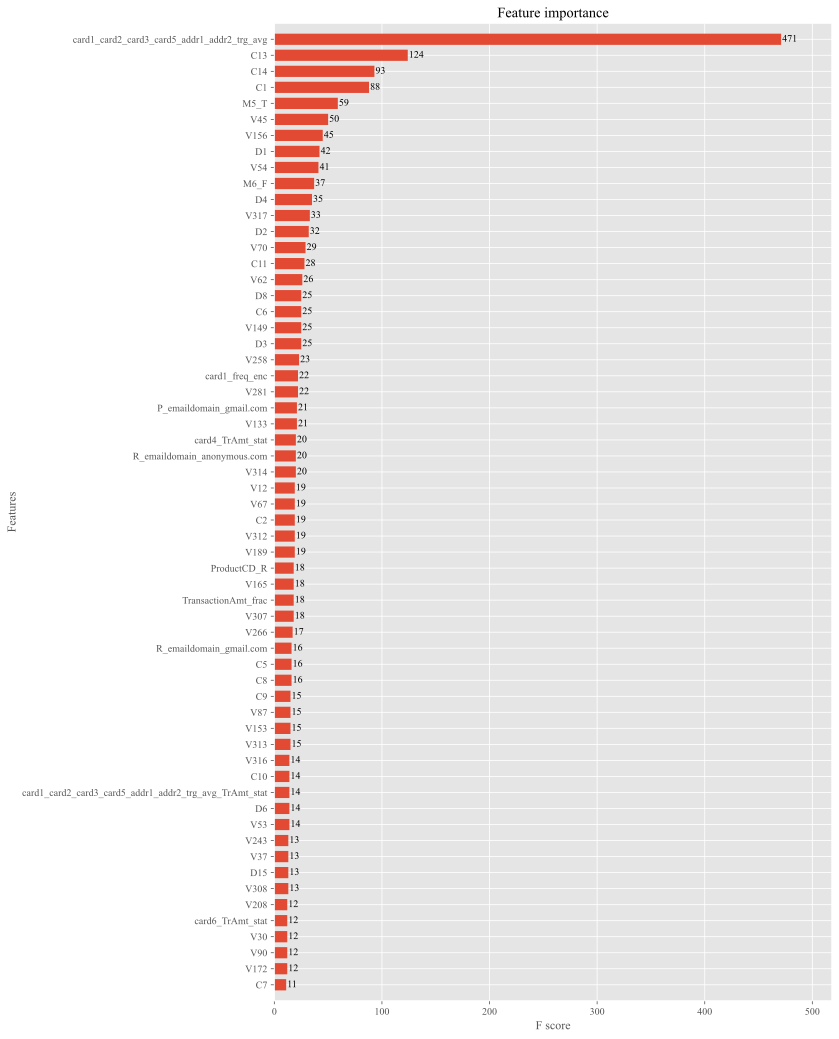

In [18]:
# importance_type задается
importance_type='weight'
max_num_features = 60
fig, ax = plt.subplots(figsize=(10, max_num_features*0.3))
xgb.plot_importance(model_xgb_1, max_num_features=max_num_features, height=0.7, ax=ax, importance_type=importance_type);

********************************

Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [19]:
# get score по умолчанию не вклчючает 0 значения
score_dict =  model_xgb_1.get_fscore()
features = []
for key in score_dict:
    if score_dict[key] > 2:
        features.append(key)
len(features)        

120

In [20]:
train_xgb_2 = xgb.DMatrix(data=X_train[features],
                            label=y_train
                            )

valid_xgb_2 = xgb.DMatrix(data=X_valid[features],
                            label=y_valid,
                            )

In [21]:
model_xgb_2 = xgb.train(
    params=params,
    dtrain=train_xgb_2,
    num_boost_round=600,
    early_stopping_rounds=50,
    evals=[(train_xgb_2, "train"), (valid_xgb_2, "valid")],
    verbose_eval=50,
    maximize=True,
)

[0]	train-auc:0.81909	valid-auc:0.81493
[50]	train-auc:0.95645	valid-auc:0.95069
[100]	train-auc:0.97415	valid-auc:0.96871
[150]	train-auc:0.97648	valid-auc:0.96998
[200]	train-auc:0.97747	valid-auc:0.97088
[250]	train-auc:0.97791	valid-auc:0.97126
[281]	train-auc:0.97791	valid-auc:0.97125


all about the same, чууууть лучше

************************

Задание 3: использовать permutation importance, выполнить задание 1 и 2.

In [22]:
xgb_params = params
xgb_params["n_estimators"] = 100

model = xgb.XGBClassifier(**xgb_params, importance_type="weight")
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='weight',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              nthread=-1, num_parallel_tree=1, random_state=13, reg_alpha=0,
              reg_lambda=100, scale_pos_weight=1, seed=13, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
y_score = model.predict_proba(X_valid)[:, 1]
score = roc_auc_score(y_valid, y_score)

print(f"Valid score = {round(score, 4)}")

Valid score = 0.9686


In [24]:
importance = permutation_importance(model,
                                    X_valid,
                                    y_valid,
                                    scoring="roc_auc",
                                    n_jobs=4,
                                    random_state=13
                                   )

In [25]:
importance_scores = pd.DataFrame({
    "features": X_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)
decrease_scores.head(2)

,features,importance-mean,importance-std
0,card5_228.0,0.0,0.0
1,card5_226.0,0.0,0.0


In [26]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame(
        {'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values(
        'importance', ascending=False)

    plt.figure(figsize=(10, len(feature_importances) * 0.3))

    sns.barplot(feature_importances['importance'],
                feature_importances['feature'])

    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

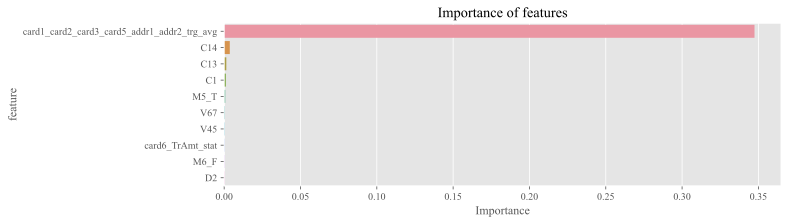

In [27]:
N = 10
imp = show_feature_importances(importance_scores['features'][:N],
                               importance_scores['importance-mean'][:N]
                               )

In [28]:
to_drop = decrease_scores['features'].tolist()

In [29]:
train_xgb_3 = xgb.DMatrix(data=X_train.drop(columns=to_drop),
                            label=y_train
                            )

valid_xgb_3 = xgb.DMatrix(data=X_valid.drop(columns=to_drop),
                            label=y_valid,
                            )

In [30]:
model_xgb_3 = xgb.train(
    params=params,
    dtrain=train_xgb_3,
    num_boost_round=600,
    early_stopping_rounds=50,
    evals=[(train_xgb_3, "train"), (valid_xgb_3, "valid")],
    verbose_eval=50,
    maximize=True,
)

[13:51:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.81909	valid-auc:0.81493
[50]	train-auc:0.95585	valid-auc:0.95067
[100]	train-auc:0.97347	valid-auc:0.96839
[150]	train-auc:0.97559	valid-auc:0.96974
[200]	train-auc:0.97626	valid-auc:0.97029
[250]	train-auc:0.97640	valid-auc:0.97032
[297]	train-auc:0.97641	valid-auc:0.97032


все примерно одинаково

***********************

Задание 5: использовать shap, выполнить задание 1 и 2.

In [31]:
import shap

In [32]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid, y_valid)

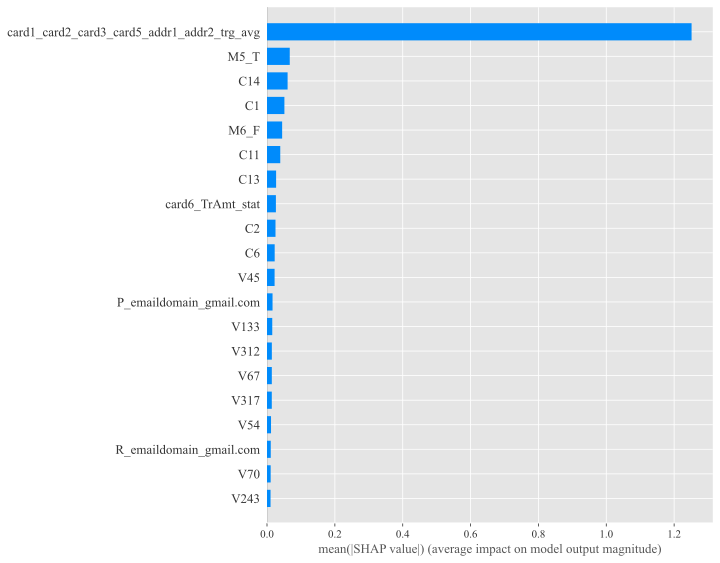

In [33]:
shap.summary_plot(shap_values, X_valid, plot_type="bar", max_display=20)

In [34]:
shap_feature_importance = pd.DataFrame(list(zip(X_valid.columns, np.abs(shap_values).mean(0))),columns=['feature','shap_values'])
shap_feature_importance.sort_values(by=['shap_values'],ascending=False,inplace=True)
shap_feature_importance.head(2)

,feature,shap_values
379,card1_card2_card3_card5_addr1_addr2_trg_avg,1.251420
1561,M5_T,0.067038


In [35]:
to_drop = shap_feature_importance[110:]['feature'].tolist()

In [36]:
train_xgb_4 = xgb.DMatrix(data=X_train.drop(columns=to_drop),
                            label=y_train
                            )

valid_xgb_4 = xgb.DMatrix(data=X_valid.drop(columns=to_drop),
                            label=y_valid,
                            )

In [37]:
model_xgb_4 = xgb.train(
    params=params,
    dtrain=train_xgb_4,
    num_boost_round=600,
    early_stopping_rounds=50,
    evals=[(train_xgb_4, "train"), (valid_xgb_4, "valid")],
    verbose_eval=50,
    maximize=True,
)

[13:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.81909	valid-auc:0.81493
[50]	train-auc:0.95646	valid-auc:0.95073
[100]	train-auc:0.97420	valid-auc:0.96871
[150]	train-auc:0.97642	valid-auc:0.97032
[200]	train-auc:0.97736	valid-auc:0.97110
[250]	train-auc:0.97753	valid-auc:0.97123
[266]	train-auc:0.97753	valid-auc:0.97123


назначительное улучшение относительно базовой модели

*********************************

Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

In [38]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = X_valid.iloc[select]
features_display = X_valid.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [-3.82540427]


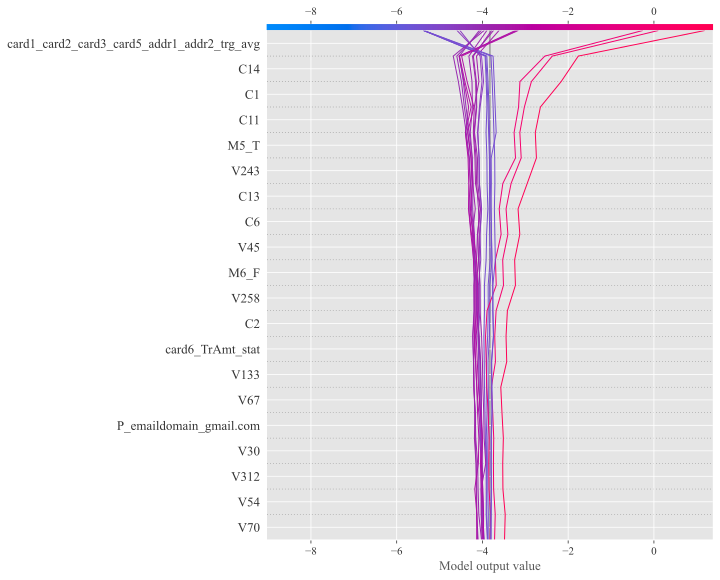

In [39]:
shap.decision_plot(
    expected_value, shap_values, features_display.iloc[:20]
)

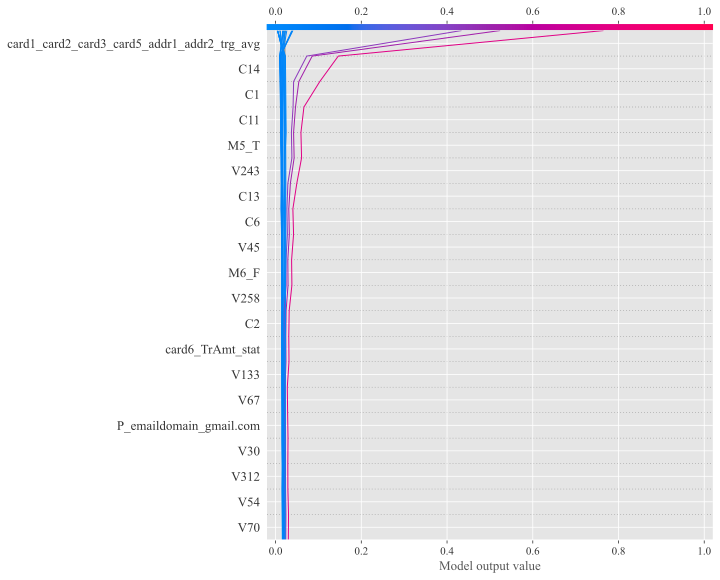

In [40]:
shap.decision_plot(expected_value, shap_values, features_display.iloc[:20], link="logit")

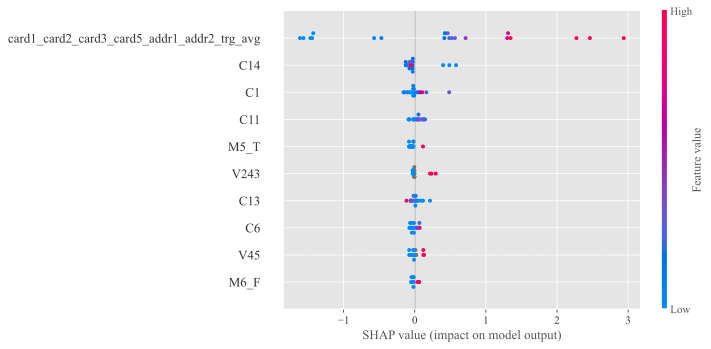

In [41]:
shap.summary_plot(shap_values, X_valid[:20], max_display=10)

То, насколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
То, насколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад
значения слева от центральной вертикальной линии — отрицательные SHAP-значения
чем краснее точка на графике, тем выше значения признака в ней


В целом сложно проследить вклад других признаков кроме как card1_card2_card3_card5_addr1_addr2_trg_avg) - по дереву решений видно, что в большинестве случаев все решается в основном одним лишь признаком. Собсвенно, предыдушие задания подтверждали вес этого признака